## Load Dataset

In [4]:
import pandas as pd

In [2]:
cols = ['sentiment','id','date','query_string','user','text']


In [5]:
df = pd.read_csv(
    'training.1600000.processed.noemoticon.csv',
    header=None,
    names=cols,
    encoding='latin-1'
)


In [6]:
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.shape

(1600000, 6)

In [6]:
df.columns

Index(['sentiment', 'id', 'date', 'query_string', 'user', 'text'], dtype='object')

In [7]:
df.dtypes


sentiment        int64
id               int64
date            object
query_string    object
user            object
text            object
dtype: object

In [8]:
df.tail()

,sentiment,id,date,query_string,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


### Cheak duplicated values

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

C:\Users\YAZHINI.YAZHNI-EM-SYS\AppData\Local\Temp\ipykernel_13668\2370506791.py:1: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [11]:
import missingno as mn

<Axes: >

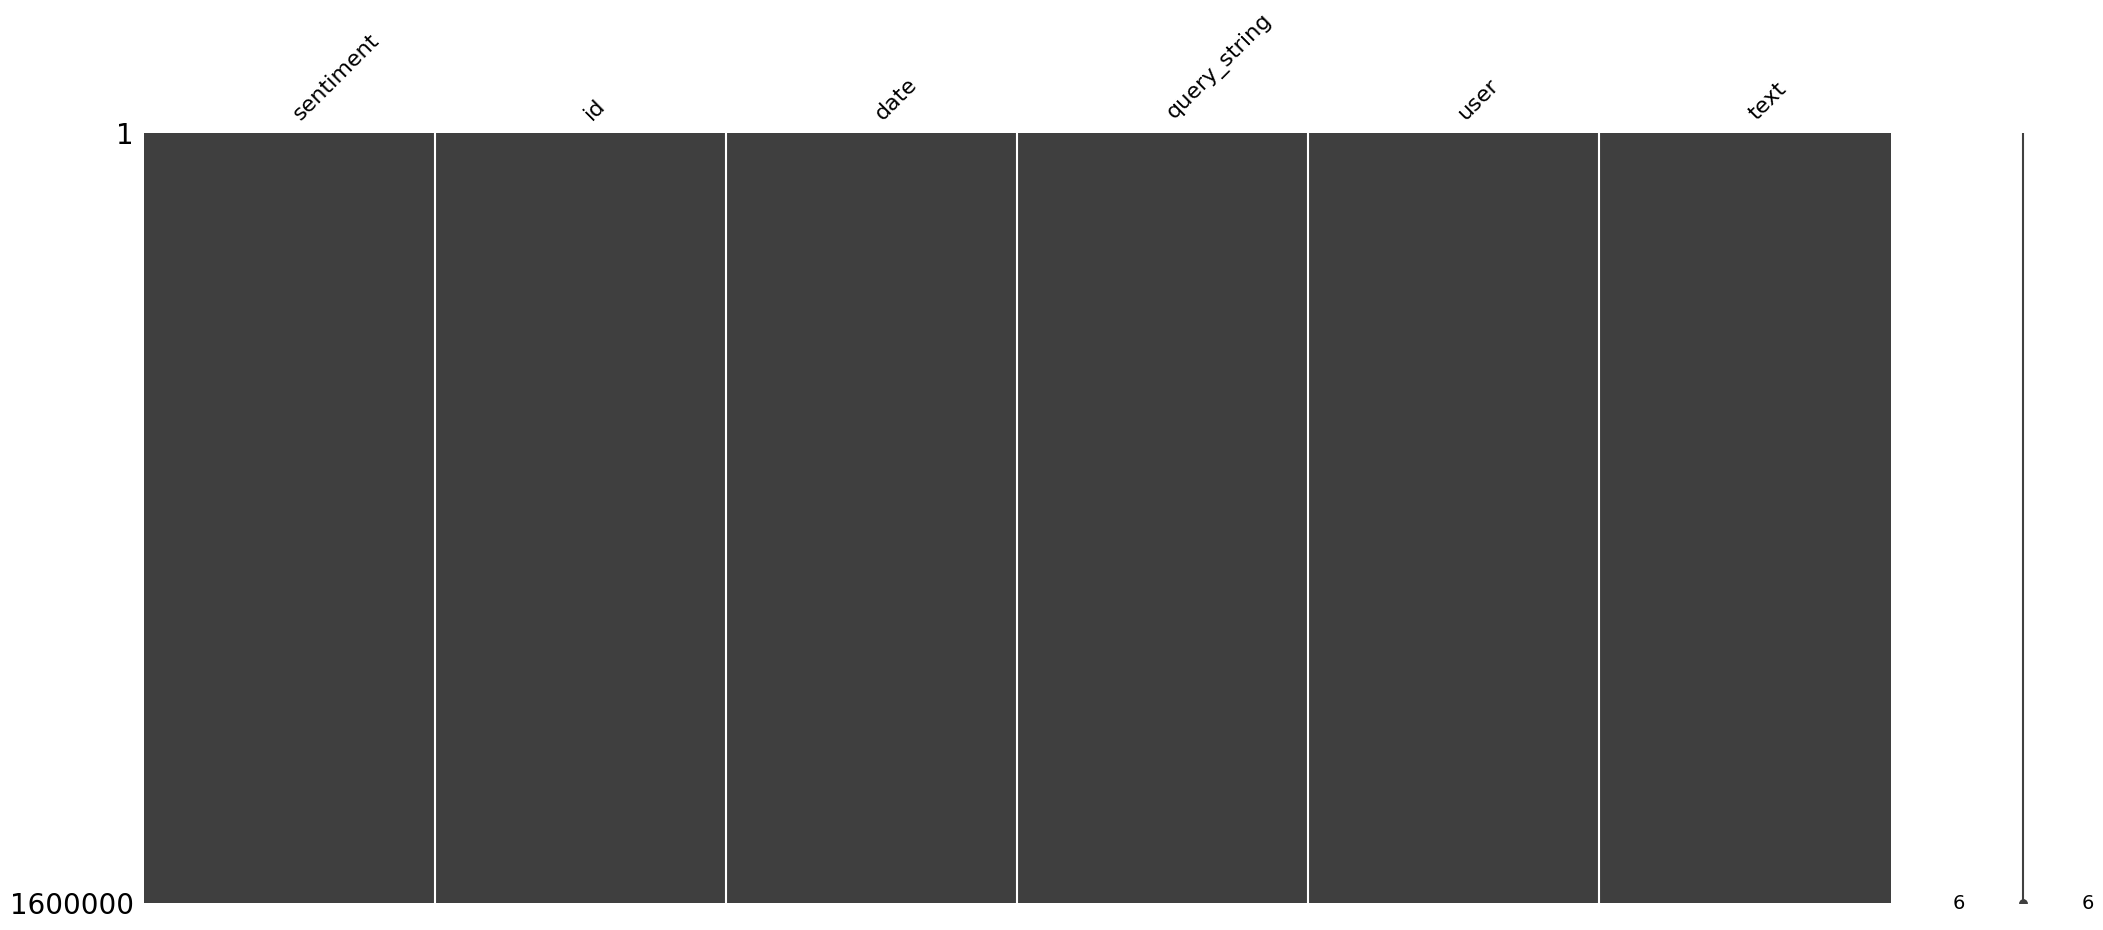

In [12]:
mn.matrix(df)

In [13]:
df = df.sample(100000, random_state=42)


In [14]:
df.shape

(100000, 6)

### Create cleaning function using Regex

In [15]:
import re
def clean_text(text):
    text = re.sub(r"http\S+", "", text)      # remove URLs
    text = re.sub(r"@\w+", "", text)         # remove mentions
    text = re.sub(r"#\w+", "", text)         # remove hashtags
    text = re.sub(r"[^A-Za-z\s]", "", text)  # remove special chars & numbers
    text = text.lower().strip()              # lowercase
    return text


## Apply to dataset

In [16]:
df['clean_text'] = df['text'].apply(clean_text)


In [17]:
df[['text','clean_text']].head()


,text,clean_text
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahhh i hope your ok
750,"@misstoriblack cool , i have no tweet apps fo...",cool i have no tweet apps for my razr
766711,@TiannaChaos i know just family drama. its la...,i know just family drama its lamehey next tim...
285055,School email won't open and I have geography ...,school email wont open and i have geography s...
705995,upper airways problem,upper airways problem


In [18]:
df.columns

Index(['sentiment', 'id', 'date', 'query_string', 'user', 'text',
       'clean_text'],
      dtype='object')

### Build Dim_Users

In [19]:
dim_users = df[['user']].drop_duplicates().reset_index(drop=True)
dim_users['user_id'] = dim_users.index + 1
dim_users.rename(columns={'user':'username'}, inplace=True)
dim_users = dim_users[['user_id','username']]

dim_users.head()

,user_id,username
0,1,LaLaLindsey0609
1,2,sexygrneyes
2,3,sammydearr
3,4,Lamb_Leanne
4,5,yogicerdito


### Build Dim_Sentiment

In [20]:
sentiment_map = {
    0: 'negative',
    2: 'neutral',
    4: 'positive'
}

dim_sentiment = pd.DataFrame({
    'sentiment_id':[0,2,4],
    'sentiment_label':['negative','neutral','positive']
})

dim_sentiment

,sentiment_id,sentiment_label
0,0,negative
1,2,neutral
2,4,positive


### Map user_id back to main dataframe

In [21]:
df = df.merge(dim_users, left_on='user', right_on='username', how='left')

In [22]:
df[['user','user_id']].head()

,user,user_id
0,LaLaLindsey0609,1
1,sexygrneyes,2
2,sammydearr,3
3,Lamb_Leanne,4
4,yogicerdito,5


### Prepare Fact table

In [23]:
fact_reviews = df[['user_id','sentiment','clean_text','date']].copy()

fact_reviews.rename(columns={
    'sentiment':'sentiment_id',
    'date':'review_time'
}, inplace=True)

### Load into MySQL

In [24]:
!pip install sqlalchemy pymysql

In [25]:
from sqlalchemy import create_engine,text

In [26]:
user = 'root'
password = 'ramya'
host = 'localhost'
port = 3306
database = 'review_dw'

In [27]:
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')

In [28]:
engine.connect()

In [29]:
from sqlalchemy import inspect

inspector = inspect(engine)
print(inspector.get_table_names())

['dim_location', 'dim_sentiment', 'dim_users', 'fact_reviews']


In [ ]:
dim_users.to_sql('Dim_Users', con=engine, if_exists='append', index=False)

dim_sentiment.to_sql('Dim_Sentiment', con=engine, if_exists='append', index=False)

fact_reviews.to_sql('Fact_Reviews', con=engine, if_exists='append', index=False)

### JSON Processing

In [32]:
import json

sample_json = [
    {
        "user": "alice",
        "location": "USA",
        "text": "I love this brand! #awesome",
        "sentiment": 4
    },
    {
        "user": "bob",
        "location": "India",
        "text": "Worst service ever!!!",
        "sentiment": 0
    }
]

In [33]:
import pandas as pd

json_df = pd.DataFrame(sample_json)
json_df

,user,location,text,sentiment
0,alice,USA,I love this brand! #awesome,4
1,bob,India,Worst service ever!!!,0


In [34]:
json_df['clean_text'] = json_df['text'].apply(clean_text)
json_df

,user,location,text,sentiment,clean_text
0,alice,USA,I love this brand! #awesome,4,i love this brand
1,bob,India,Worst service ever!!!,0,worst service ever


In [35]:
users_list = [u for u in json_df['user'].unique()]
users_list

['alice', 'bob']

In [36]:
df['sentiment'].value_counts()

sentiment
4    50057
0    49943
Name: count, dtype: int64

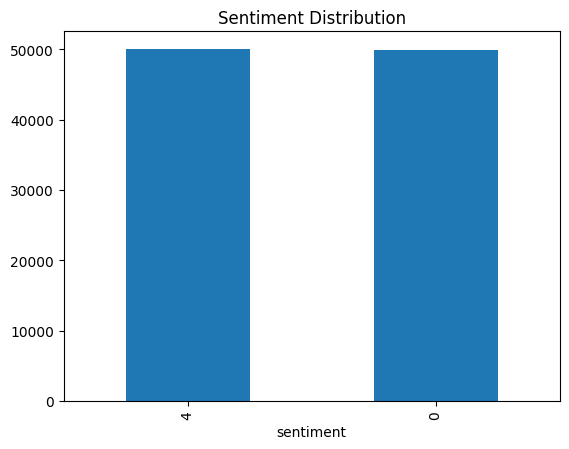

In [37]:
import matplotlib.pyplot as plt

df['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.show()

In [38]:
df['text_length'] = df['clean_text'].apply(len)

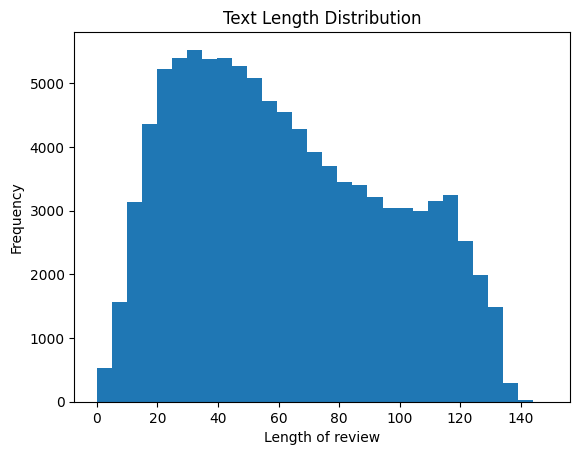

In [39]:
import matplotlib.pyplot as plt

plt.hist(df['text_length'], bins=30)
plt.title("Text Length Distribution")
plt.xlabel("Length of review")
plt.ylabel("Frequency")
plt.show()

## Clustering (K-Means)
### Import libraries

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

### Convert text → TF-IDF

In [41]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000
)

X_tfidf = tfidf.fit_transform(df['clean_text'])

### K-Means

In [42]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['topic_cluster'] = kmeans.fit_predict(X_tfidf)

In [43]:
df[['clean_text','topic_cluster']].head(10)

,clean_text,topic_cluster
0,ahhh i hope your ok,1
1,cool i have no tweet apps for my razr,1
2,i know just family drama its lamehey next tim...,2
3,school email wont open and i have geography s...,1
4,upper airways problem,1
5,going to miss pastors sermon on faith,1
6,on lunchdj should come eat with me,1
7,oh why are you feeling like that,1
8,gahh noopeyton needs to livethis is horrible,1
9,thank you glad you like it there is a product ...,1


In [44]:
df['topic_cluster'].value_counts()

topic_cluster
1    85693
2    10659
0     3648
Name: count, dtype: int64

### Create label column

In [45]:
df['review_type'] = df['clean_text'].apply(
    lambda x: 'Noise' if len(x.split()) < 3 else 'Constructive'
)

In [46]:
X = df['clean_text']
y = df['review_type']

### TF-IDF vectorization

In [51]:
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)

tfidf_matrix = vectorizer.fit_transform(df['clean_text'])

terms = vectorizer.get_feature_names_out()

for i in range(3):
    center_terms = kmeans.cluster_centers_[i].argsort()[-10:]
    print(f"\nCluster {i} top words:")
    print([terms[j] for j in center_terms])


Cluster 0 top words:
['tips', 'dough', 'kate', 'hols', 'gold', 'tongue', 'toes', 'ima', 'dayy', 'worked']

Cluster 1 top words:
['tips', 'looking', 'thesis', 'toes', 'gold', 'limits', 'loyal', 'dayy', 'goodbye', 'ima']

Cluster 2 top words:
['goodbye', 'looking', 'thou', 'wasnt', 'limits', 'gotcha', 'ima', 'korea', 'dough', 'kate']


### Train/Test split

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [52]:
df['clean_text'].isnull().sum()

np.int64(0)

### TF-IDF for classifier

In [57]:
clf_vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = clf_vectorizer.fit_transform(X_train)
X_test_tfidf = clf_vectorizer.transform(X_test)

### Logistic Regression model

In [58]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


### Prediction

In [59]:
y_pred = model.predict(X_test_tfidf)

### Classification Report

In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

Constructive       0.97      1.00      0.98     19256
       Noise       0.83      0.23      0.36       744

    accuracy                           0.97     20000
   macro avg       0.90      0.61      0.67     20000
weighted avg       0.97      0.97      0.96     20000



### EDA Pivot Table

In [61]:
pivot = pd.pivot_table(
    df,
    index='topic_cluster',
    columns='sentiment',
    aggfunc='size',
    fill_value=0
)

print(pivot)

sentiment          0      4
topic_cluster              
0               2585   1063
1              41464  44229
2               5894   4765


### Install PyTorch

In [62]:
!pip install torch

In [63]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

### Create anger score

In [64]:
def map_anger(sentiment):
    if sentiment == 0:
        return 1.0   # negative → high anger
    elif sentiment == 4:
        return 0.0   # positive → low anger
    else:
        return 0.5   # neutral

df['anger_score'] = df['sentiment'].apply(map_anger)

df[['sentiment','anger_score']].head()

,sentiment,anger_score
0,0,1.0
1,0,1.0
2,0,1.0
3,0,1.0
4,0,1.0


### Build vocabulary

In [65]:
from collections import Counter

all_words = ' '.join(df['clean_text']).split()
counter = Counter(all_words)

vocab = {word:i+1 for i,(word,_) in enumerate(counter.most_common(10000))}
vocab_size = len(vocab) + 1

print("Vocab size:", vocab_size)

Vocab size: 10001


### Text → sequence converter

In [66]:
max_len = 30

def text_to_seq(text):
    seq = [vocab.get(word, 0) for word in text.split()]
    if len(seq) < max_len:
        seq += [0] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return seq

### Create PyTorch Dataset

In [67]:
class ReviewDataset(Dataset):
    def __init__(self, df):
        self.texts = df['clean_text'].values
        self.targets = df['anger_score'].values.astype(np.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        seq = text_to_seq(self.texts[idx])
        return (
            torch.tensor(seq, dtype=torch.long),
            torch.tensor(self.targets[idx], dtype=torch.float32)
        )

### DataLoader

In [68]:
dataset = ReviewDataset(df)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

### LSTM Model

In [69]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 64)
        self.lstm = nn.LSTM(64, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        out = self.sigmoid(out)
        return out.squeeze()

### Initialize model

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(vocab_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Using device:", device)

Using device: cpu


### Training loop

In [72]:
epochs = 2  # keep small due to time

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        preds = model(X_batch)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 257.5104
Epoch 2, Loss: 194.4509


### Test prediction

In [73]:
model.eval()

sample_text = df['clean_text'].iloc[0]
sample_seq = torch.tensor(text_to_seq(sample_text)).unsqueeze(0).to(device)

with torch.no_grad():
    anger_pred = model(sample_seq).item()

print("Sample anger score:", anger_pred)

Sample anger score: 0.4309269189834595


### Chi-Square Test

In [83]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')

contingency = pd.crosstab(df['sentiment'], df['month'])
print(contingency.shape)

(2, 3)


In [85]:
from scipy.stats import chi2_contingency
import pandas as pd

# create contingency table
contingency = pd.crosstab(df['sentiment'], df['query_string'])

chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square value:", chi2)
print("p-value:", p)

if p < 0.05:
    print("Result: Statistically significant relationship")
else:
    print("Result: No significant relationship")

Chi-square value: 0.0
p-value: 1.0
Result: No significant relationship


### Pivot Table

In [86]:
pivot_table = pd.pivot_table(
    df,
    values='id',
    index='query_string',
    columns='sentiment',
    aggfunc='count',
    fill_value=0
)

pivot_table

sentiment,0,4
query_string,,
NO_QUERY,49943,50057


### WordCloud

In [76]:
!pip install wordcloud

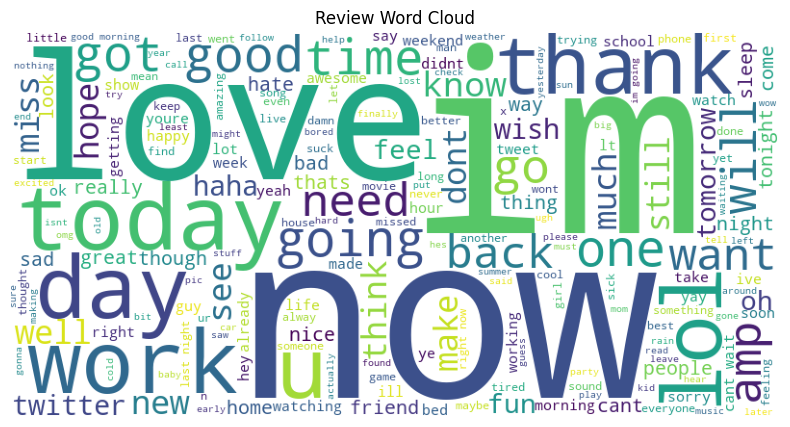

In [87]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_blob = ' '.join(df['clean_text'])

wc = WordCloud(width=800, height=400, background_color='white').generate(text_blob)

plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.title("Review Word Cloud")
plt.show()

### Donut Chart (sentiment distribution)

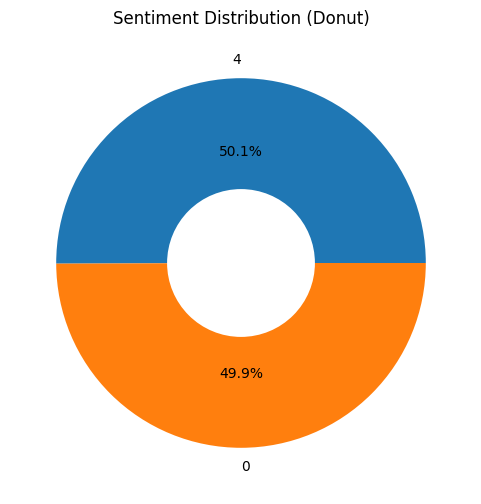

In [88]:
sent_counts = df['sentiment'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(sent_counts, labels=sent_counts.index, autopct='%1.1f%%')
plt.gca().add_artist(plt.Circle((0,0),0.40,fc='white'))
plt.title("Sentiment Distribution (Donut)")
plt.show()

### Stacked Bar

In [89]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

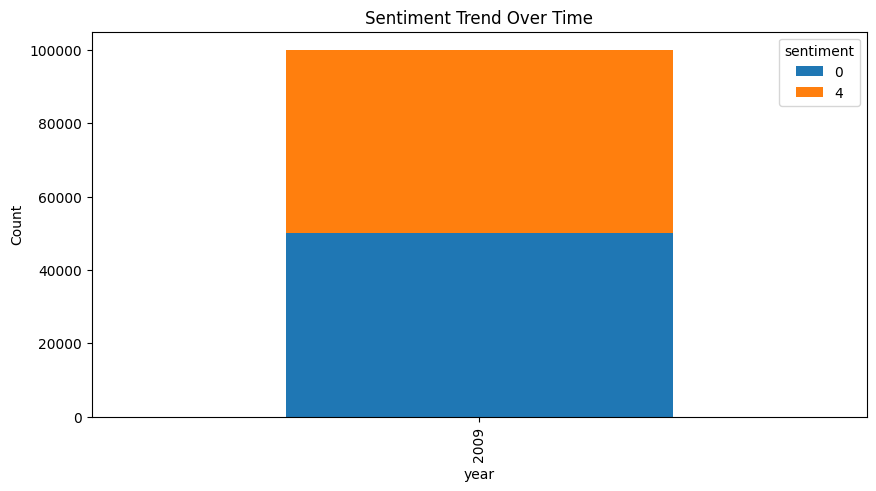

In [90]:
trend = pd.crosstab(df['year'], df['sentiment'])

trend.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title("Sentiment Trend Over Time")
plt.ylabel("Count")
plt.show()

### model save

In [91]:
torch.save(model.state_dict(), "voxpop_anger_model.pt")

In [92]:
%%writefile app1.py
import streamlit as st

Writing app1.py


In [7]:
df.to_csv("sample_reviews.csv", index=False)

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
